# Setup


In [1]:
from scripts.visualize_box_version import prepare_dataset_and_model
import numpy as np

args, model, train_dataset, box_data,box_file = prepare_dataset_and_model(args_location="test/partitionv2_simedge2_unit1_woCLIP_1500/args.json",ckpt_epoch=400)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
model loaded!
training statistics collected


In [2]:
from scripts.visualize_box_version import generate_queried_unit_mesh
objs = [2, 1, 3, 4, 5, 6]
triples = [[2, 1, 5],[2, 1, 4],[5, 1, 4],[3, 3, 1],[3, 3, 0],[5, 2, 3],[2, 2, 3],[4, 2, 3]]

model_file_path = generate_queried_unit_mesh(
        input_objs=objs,
        input_triples=triples,
        unit_box = [3.,5.,4.],
        args=args,
        model=model,
        train_dataset=train_dataset,
    )

start boolean difference..


In [2]:
if "unit_box_mean" not in args:
        unit_box_mean = train_dataset.unit_box_mean
        unit_box_std = train_dataset.unit_box_std
else:
    unit_box_mean = np.array(args["unit_box_mean"])
    unit_box_std = np.array(args["unit_box_std"])

obj_idx2name = {v: k for k, v in train_dataset.classes.items()}
rel_idx2name = {k + 1: v for k, v in enumerate(train_dataset.relationships)}
rel_idx2name[0] = "belong to"
device = args['device']
adj_rel_idx = train_dataset.relationships_dict["adjacent to"]

# Retrieve One Graph from Train Dataset


In [3]:
# input idx of data in the dataset to retrieve the graph and corresponding data
from helpers.visualize_graph import visualize_scene_graph
query_idx = 2

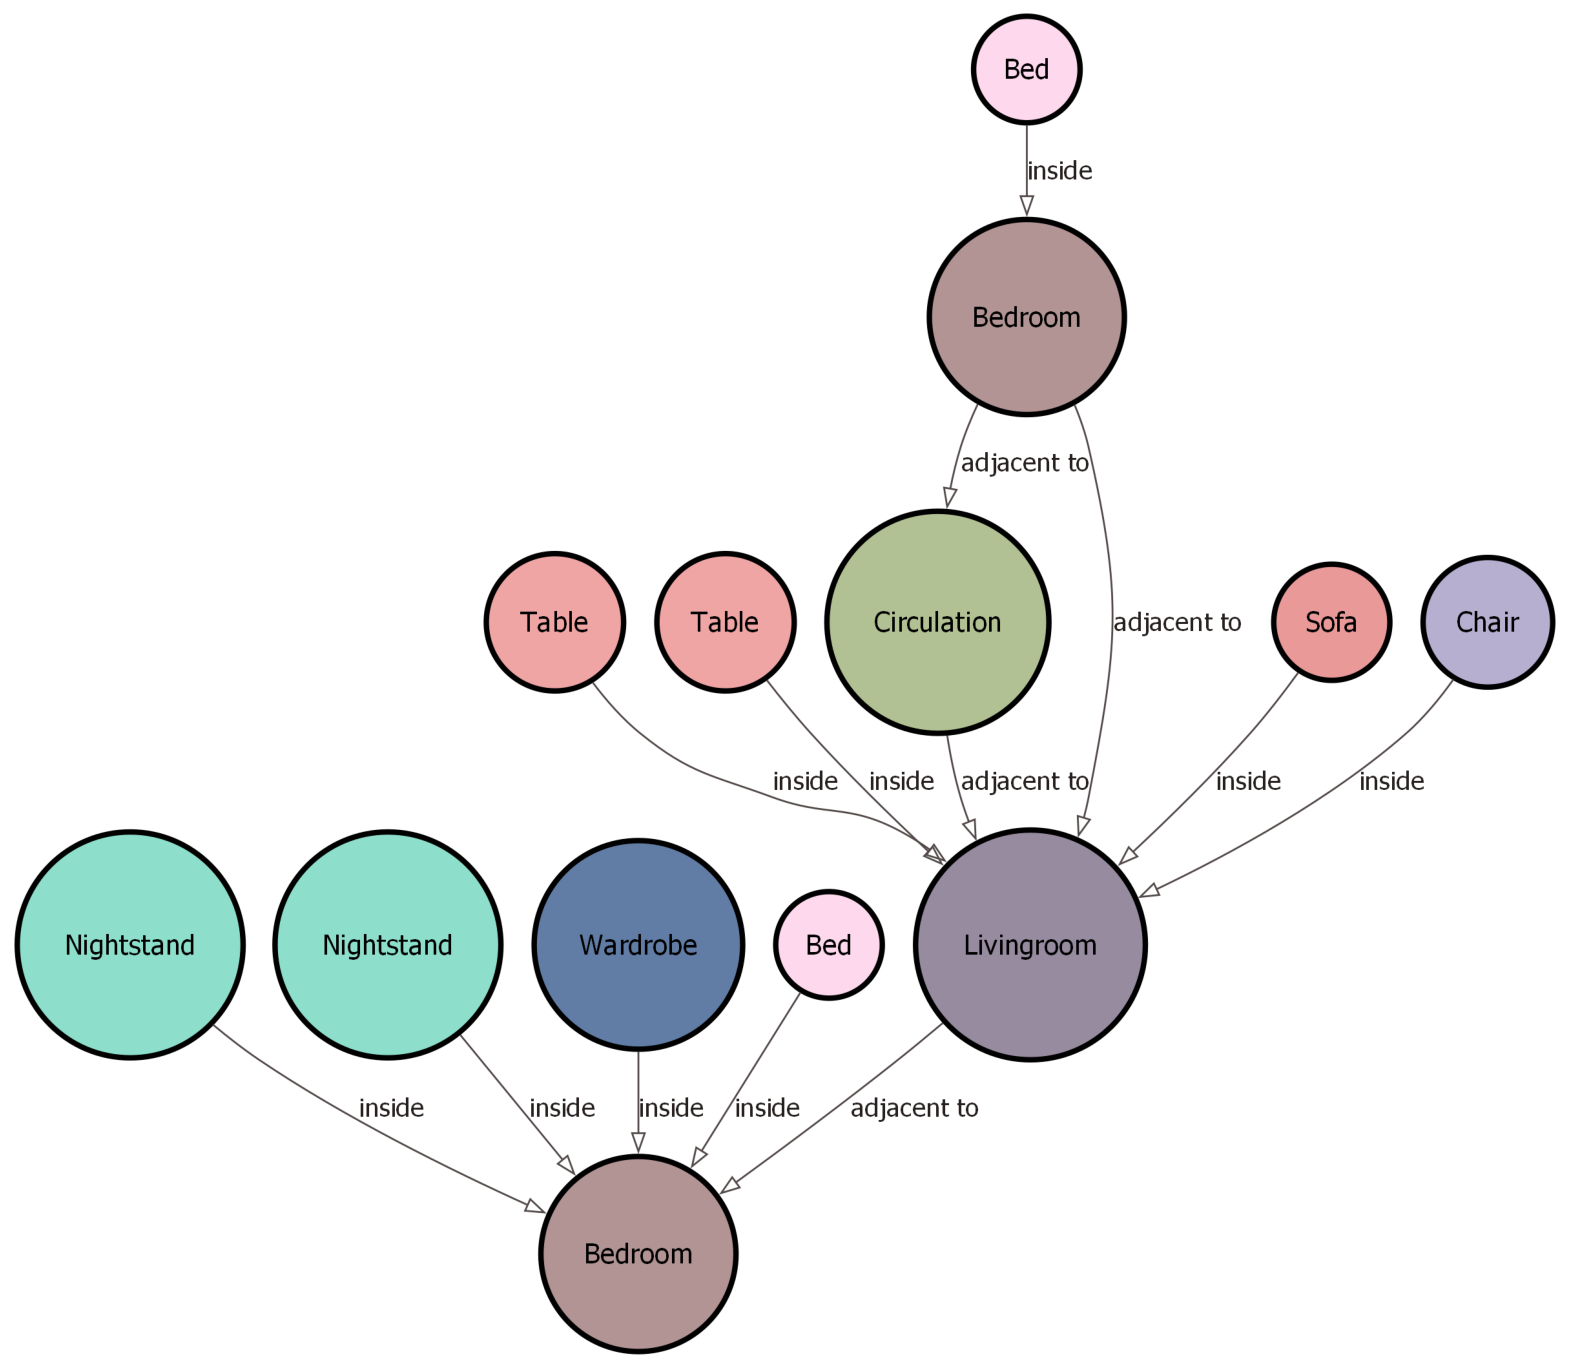

tensor([18,  4,  7,  3, 14, 16, 18, 13,  3, 19,  4, 14,  6,  0])
tensor([[12,  1,  6],
        [ 2,  3,  7],
        [ 4,  2,  1],
        [11,  1,  4],
        [ 0,  2,  7],
        [ 6,  2,  7],
        [11,  2,  1],
        [12,  1,  5],
        [ 9,  2,  1],
        [ 3,  2, 10],
        [ 5,  2,  7],
        [ 8,  2,  1],
        [ 9,  1,  8],
        [10,  3,  2],
        [ 8,  1, 11],
        [ 8,  1,  4],
        [ 5,  1,  6],
        [10,  3,  7],
        [12,  2,  7],
        [ 7,  3,  1],
        [ 1,  0, 13],
        [ 2,  0, 13],
        [ 7,  0, 13],
        [10,  0, 13]])


In [4]:

# parse data
data = train_dataset[query_idx]
dec_objs_grained = data["decoder"]["objs_grained"]
dec_objs = data["decoder"]["objs"]
dec_triples = data["decoder"]["triples"]
if args['with_CLIP']:
    dec_rel_feat = data["decoder"]["rel_feats"]
    dec_text_feat = data["decoder"]["text_feats"]
dec_unit_box = data["decoder"]["unit_box"]
obj_to_pidx = data["decoder"]["obj_to_pidx"]
boxes_gt = data["decoder"][
    "boxes"
]  # TODO: directly denormalization seems problematic, check!!
instances = data["instance_id"][0]
if "sdfs" in data["decoder"]:
    dec_sdfs = data["decoder"]["sdfs"]
scan = data["scan_id"][0]
dec_objs, dec_triples, dec_unit_box = (
    dec_objs.to(device),
    dec_triples.to(device),
    dec_unit_box.to(device),
)

visualize_scene_graph(
    dec_triples.numpy(),
    dec_objs.numpy(),
    obj_idx2name,
    rel_idx2name,
    obj_class_to_color=args["dataset"] + "/class_color.json",
    included_relations=[
        "inside",
        "adjacent to",
    ],
)

print(dec_objs)
print(dec_triples)

# Visualize Boxes using Plotly


In [5]:
from scripts.visualize_box_version import predict_boxes_and_angles,rationalize_box_params
from helpers.viz_util import render_plotly_sdf

# for custom bounding box input, change the is_custom_boundary to True, and put the input bbox array in unit_box 

boxes_pred_den, angles_pred,dec_unit_box = predict_boxes_and_angles(
    is_custom_boundary=False,  # True if custom bbox 
    device="cpu",
    random_seed=852,
    model=model,
    unit_box=None,
    args=args,
    data=data,
    unit_box_mean=unit_box_mean,
    unit_box_std=unit_box_std,
    box_file = box_file
)


In [6]:
box_points, denormalized_boxes, angles_pred = rationalize_box_params(
    boxes_pred_den, angles_pred, unit_box_mean, unit_box_std, dec_unit_box, data,adj_rel_idx
)
render_plotly_sdf(
    box_points,

    obj_idx2name=obj_idx2name,
    objs=dec_objs,

    shapes_pred=None,

    render_shapes=False,

    render_boxes=True,

    colors=args["dataset"] + "/class_color.json",

    save_as_image=False,

    filename=f"{args['exp']}/scene_render.png",
    obj_to_pidx=obj_to_pidx,

)

# Export Meshes


In [7]:
import json
import os
from helpers.viz_util import create_scene_meshes,export_scene_meshes
detailed_obj_class = train_dataset.vocab["full_object_idx_to_name_grained"]
sdf_dir = "DEEPSDF_reconstruction/Meshes"
# get furniture category
fur_cat_file = args["dataset"] + "/cat_jid_all.json"
with open(fur_cat_file, "r") as file:
    fur_cat = json.load(file)
# trimesh mesh object
meshes,_,_ = create_scene_meshes(
    dec_objs_grained,
    obj_to_pidx,
    denormalized_boxes,
    angles_pred,
    detailed_obj_class,
    fur_cat,
    sdf_dir,
    retrieve_sdf = False, # export box only meshes
)


start boolean difference..


In [11]:
import trimesh
scene = trimesh.Scene(meshes)
scene.show()

In [8]:
exp_dir = os.path.join(args['exp'],'mesh')
mesh_name = f'{data["scan_id"]}.obj'
exp_path = os.path.join(exp_dir,mesh_name)
print(exp_path)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir,exist_ok = True)
export_scene_meshes(meshes,dec_objs,obj_idx2name,exp_path)

test/partitionv2_simedge2_unit1_woCLIP_1500\mesh\00321452-517d-431b-a21b-f52750684910-4room.obj
